In [3]:
!pip install pybind11

In [5]:
!pip install ninja

In [6]:
pip install --upgrade pybind11


Note: you may need to restart the kernel to use updated packages.


In [7]:
import pybind11
print(pybind11.get_include())


/Users/kinakim/opt/anaconda3/envs/newenv/lib/python3.8/site-packages/pybind11/include


In [8]:
!pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv

  Using cached torch_scatter-2.1.2.tar.gz (108 kB)
  Preparing metadata (setup.py) ... done
  Using cached torch_sparse-0.6.18.tar.gz (209 kB)
  Preparing metadata (setup.py) ... done
  Using cached torch_cluster-1.6.3.tar.gz (54 kB)
  Preparing metadata (setup.py) ... done
  Using cached torch_spline_conv-1.2.2.tar.gz (25 kB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [45 lines of output]
      Compiling without OpenMP...
      Compiling without OpenMP...
      Compiling without OpenMP...
      Compiling without OpenMP...
      running bdist_wheel
      running build
      running build_py
      creating build/lib.macosx-10.15-x86_64-cpython-38/torch_scatter
      copying torch_scatter/placeholder.py -> build/lib.macosx-10.15-x86_64-cpython-38/torch_scatter
      copying torch_scatter/__init__.py -> build/lib.macosx-10.15-x86_64-cpython-38/torch_scatter
      copying

In [45]:
!pip install seaborn

In [2]:
import torch 
from torch_geometric.datasets import TUDataset
import networkx as nx 
import matplotlib.pyplot as plt 
from collections import Counter 
import numpy as np 

# Load dataset 
dataset = TUDataset(root="data", name="ENZYMES")

# Print 
print("Number of Graphs: ", len(dataset))
print("Number of node features:", dataset.num_node_features)
print("Number of classes:", dataset.num_classes)

# Class distribution 
labels = [data.y.item() for data in dataset]
label_counts = Counter(labels) 
print("Class distribution:", label_counts)

/Users/kinakim/opt/anaconda3/envs/newenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of Graphs:  600
Number of node features: 3
Number of classes: 6
Class distribution: Counter({5: 100, 4: 100, 0: 100, 1: 100, 2: 100, 3: 100})


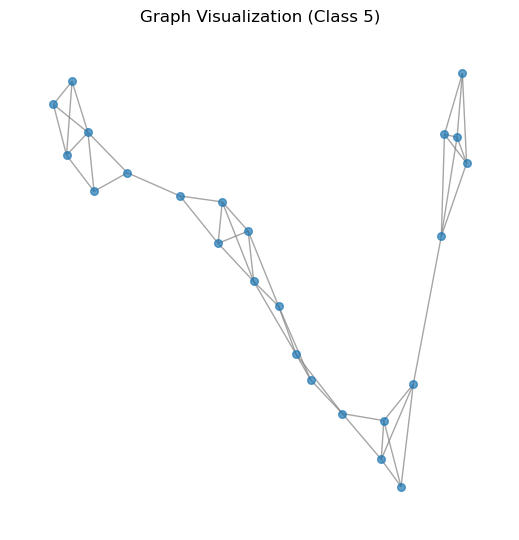

In [3]:
# Function to visualize a sample graph
def plot_graph(data):
    """Visualizes a graph using NetworkX."""
    edge_index = data.edge_index.numpy()
    graph = nx.Graph()
    graph.add_edges_from(edge_index.T)

    plt.figure(figsize=(5, 5))
    nx.draw(graph, node_size=30, edge_color="gray", alpha=0.7, with_labels=False)
    plt.title(f"Graph Visualization (Class {data.y.item()})")
    plt.show()

# Plot the first graph
plot_graph(dataset[3])


Attempt1: DVNE <br>
A Deep Variational Network Embedding (DVNE) is a Variational Graph Autoencoder (VGAE), which:<br>

Learns probabilistic latent representations instead of deterministic embeddings. <br>
Uses a reparameterization trick to sample embeddings from a Gaussian distribution.<br>
Helps capture uncertainty in graph representations.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_max_pool, BatchNorm

class DVNE_Encoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_dim, latent_dim, num_heads=4, dropout=0.2):  # CHANGED: Added dropout
        super(DVNE_Encoder, self).__init__()
        
        # CHANGED: Added another GATConv layer for deeper feature extraction
        self.conv1 = GATConv(in_channels, hidden_dim, heads=num_heads, concat=True)
        self.conv2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads, concat=True)
        
        self.conv_mu = GATConv(hidden_dim * num_heads, latent_dim, heads=1, concat=False)   
        self.conv_logvar = GATConv(hidden_dim * num_heads, latent_dim, heads=1, concat=False) 
        
        # CHANGED: Added BatchNorm and Dropout
        self.batch_norm = BatchNorm(hidden_dim * num_heads)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))  
        x = self.batch_norm(x)  # CHANGED: Normalize features
        x = self.dropout(x)  # CHANGED: Regularization
        
        x = F.relu(self.conv2(x, edge_index))  # CHANGED: Extra GATConv layer
        x = self.batch_norm(x)  # CHANGED: Normalize again
        x = self.dropout(x)  
        
        mu = self.conv_mu(x, edge_index)  
        logvar = self.conv_logvar(x, edge_index) 
        
        mu = global_max_pool(mu, batch)  
        logvar = global_max_pool(logvar, batch)  
        
        logvar = torch.clamp(logvar, min=-5, max=5)  # CHANGED: Less aggressive clamping

        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  
        eps = torch.randn_like(std)  
        return mu + eps * std  

class DVNE_Decoder(torch.nn.Module):
    def __init__(self, latent_dim):
        super(DVNE_Decoder, self).__init__()
        self.linear = nn.Linear(latent_dim, latent_dim)

    def forward(self, z):
        return torch.sigmoid(self.linear(z))


def dvne_loss(mu, logvar, z, z_recon, alpha=0.6, beta=1.0):  # CHANGED: Increased beta weight
    norm_z = F.normalize(z, p=2, dim=1)  
    cosine_sim = torch.mm(norm_z, norm_z.T)  
    cosine_dist = 1 - cosine_sim  
    
    # CHANGED: Hard negative mining (focus on hardest 10% negatives)
    margin = torch.quantile(cosine_dist, 0.9) * 0.1  
    ranking_loss = torch.clamp(margin - cosine_dist, min=0).mean()
    
    recon_loss = 0.7 * F.mse_loss(z_recon, z) + 0.3 * F.l1_loss(z_recon, z)  
    
    prior_mu = torch.zeros_like(mu)
    prior_logvar = torch.zeros_like(logvar)

    kl_div = 0.5 * torch.sum(
        torch.exp(logvar - prior_logvar) + (mu - prior_mu) ** 2 / torch.exp(prior_logvar) - 1 - (logvar - prior_logvar),
        dim=1
    ).mean()

    total_loss = alpha * ranking_loss + (1 - alpha) * recon_loss + beta * kl_div  
    
    return total_loss, ranking_loss, recon_loss, kl_div

# Alternative: Contrastive Loss (disabled by default)
# def contrastive_loss(z, y, margin=0.5):  # CHANGED: Added Contrastive Loss alternative
#     dists = torch.cdist(z, z, p=2)  
#     loss = (1 - y) * dists ** 2 + y * torch.clamp(margin - dists, min=0) ** 2
#     return loss.mean()

# CHANGED: Now supports contrastive loss as an option
# total_loss = alpha * contrastive_loss(z, y) + (1 - alpha) * recon_loss + beta * kl_div


In [6]:
def extract_dvne_embeddings(model, loader):
    model.eval()
    embeddings, labels = [], []
    with torch.no_grad():
        for data in loader:
            # data = data.to(device)
            _, _, _, z = model(data.x, data.edge_index, data.batch)
            embeddings.append(z.cpu())
            labels.append(data.y.cpu())
    return torch.cat(embeddings), torch.cat(labels)


In [18]:
from torch_geometric.data import DataLoader

# Split dataset
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [480, 120])

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"Train graphs: {len(train_dataset)}, Test graphs: {len(test_dataset)}")

Train graphs: 480, Test graphs: 120


/Users/kinakim/opt/anaconda3/envs/newenv/lib/python3.8/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
encoder = DVNE_Encoder(in_channels=dataset.num_features, hidden_dim=128, latent_dim=64)
decoder = DVNE_Decoder(latent_dim=64) #align with encoder

optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)

# Training loop
for epoch in range(100):
    encoder.train()
    decoder.train()
    total_loss = 0
    total_ranking_loss = 0 
    total_recon_loss = 0 
    total_KL_div = 0 


    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()

        mu, logvar = encoder(data.x, data.edge_index, data.batch)
        z = encoder.reparameterize(mu, logvar)  # Sample embeddings

        reconstructed = decoder(z)  # Reconstruction (if needed)
        
        loss, ranking_loss, recon_loss, kl_div = dvne_loss(mu, logvar, z, reconstructed)  # Compute KL divergence in Wasserstein space
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_ranking_loss += ranking_loss.item()
        total_recon_loss += recon_loss.item() 
        total_KL_div += kl_div.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Ranking Loss: {total_ranking_loss:.4f}, Reconstruction Loss: {total_recon_loss:.4f}, KL Divergence: {total_KL_div:.4f}")


Epoch 1, Loss: 2708.0140, Ranking Loss: 0.1869, Reconstruction Loss: 98.9304, KL Divergence: 2668.3297
Epoch 2, Loss: 824.5955, Ranking Loss: 0.1953, Reconstruction Loss: 55.2570, KL Divergence: 802.3755
Epoch 3, Loss: 504.5945, Ranking Loss: 0.2014, Reconstruction Loss: 47.1601, KL Divergence: 485.6097
Epoch 4, Loss: 375.4946, Ranking Loss: 0.2075, Reconstruction Loss: 45.0446, KL Divergence: 357.3523
Epoch 5, Loss: 269.3634, Ranking Loss: 0.2119, Reconstruction Loss: 42.2044, KL Divergence: 252.3545
Epoch 6, Loss: 208.5570, Ranking Loss: 0.2145, Reconstruction Loss: 39.8452, KL Divergence: 192.4902
Epoch 7, Loss: 178.9624, Ranking Loss: 0.2164, Reconstruction Loss: 38.7180, KL Divergence: 163.3453
Epoch 8, Loss: 155.3350, Ranking Loss: 0.2159, Reconstruction Loss: 37.8491, KL Divergence: 140.0658
Epoch 9, Loss: 146.7406, Ranking Loss: 0.2169, Reconstruction Loss: 36.8979, KL Divergence: 131.8512
Epoch 10, Loss: 119.1788, Ranking Loss: 0.2166, Reconstruction Loss: 35.2126, KL Divergen

In [20]:
def extract_dvne_embeddings(encoder, loader):
    encoder.eval()
    embeddings, labels = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            mu, logvar = encoder(data.x, data.edge_index, data.batch)  # Get mu and logvar
            z = encoder.reparameterize(mu, logvar)  # Sample latent embedding
            embeddings.append(z.cpu())
            labels.append(data.y.cpu())
    
    return torch.cat(embeddings), torch.cat(labels)

# Extract embeddings
train_embeddings, train_labels = extract_dvne_embeddings(encoder, train_loader)
test_embeddings, test_labels = extract_dvne_embeddings(encoder, test_loader)

print(f"Train embeddings shape: {train_embeddings.shape}")
print(f"Test embeddings shape: {test_embeddings.shape}")

Train embeddings shape: torch.Size([480, 64])
Test embeddings shape: torch.Size([120, 64])


In [21]:
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
# import numpy as np

# def visualize_embeddings_3d(embeddings, labels, method="tsne"):
#     num_classes = len(set(labels.numpy()))  # Get number of unique classes

#     # Reduce dimensionality
#     if method == "tsne":
#         reducer = TSNE(n_components=3, perplexity=30, random_state=42)
#     else:
#         reducer = PCA(n_components=3)

#     reduced_embeddings = reducer.fit_transform(embeddings.numpy())

#     # Create a 3D figure
#     fig = plt.figure(figsize=(10, 8))
#     ax = fig.add_subplot(111, projection='3d')  # 3D axis

#     # Convert labels to an integer array for color mapping
#     unique_labels = np.unique(labels.numpy())
#     color_mapping = {label: i for i, label in enumerate(unique_labels)}
#     mapped_colors = np.array([color_mapping[label] for label in labels.numpy()])

#     # Scatter plot
#     scatter = ax.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], reduced_embeddings[:, 2], 
#                          c=mapped_colors, cmap="tab10", alpha=0.7)

#     # Labels and title
#     ax.set_title(f"Graph Embeddings Visualization using {method.upper()}", fontsize=12)
#     ax.set_xlabel("Component 1")
#     ax.set_ylabel("Component 2")
#     ax.set_zlabel("Component 3")

#     # Add color legend
#     cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
#     cbar.set_label("Class Label")

#     plt.show()

# # Visualize 3D embeddings
# visualize_embeddings_3d(test_embeddings, test_labels, method="tsne")


In [22]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming embeddings are stored in 'z'
tsne = TSNE(n_components=2)
z_2d = tsne.fit_transform(z.detach().cpu().numpy())

plt.scatter(z_2d[:, 0], z_2d[:, 1], c=data.y.cpu(), cmap='jet')
plt.colorbar()
plt.show()


ValueError: perplexity must be less than n_samples

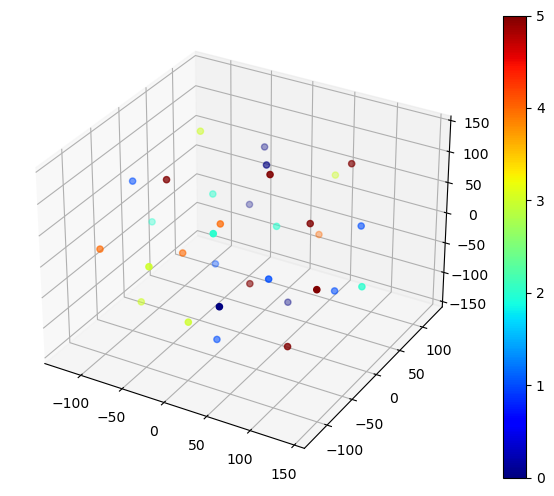

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting

# Assuming embeddings are stored in 'z'
tsne = TSNE(n_components=3)
z_3d = tsne.fit_transform(z.detach().cpu().numpy())

# Create a 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(z_3d[:, 0], z_3d[:, 1], z_3d[:, 2], c=data.y.cpu(), cmap='jet')

# Add color bar
plt.colorbar(sc)
plt.show()

In [ ]:
## Classifier on Latent Representations
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Train logistic regression on learned embeddings
clf = LogisticRegression(max_iter=1000)
clf.fit(train_embeddings.numpy(), train_labels.numpy())

# Evaluate classifier
preds = clf.predict(test_embeddings.numpy())
accuracy = accuracy_score(test_labels.numpy(), preds)

print(f"Graph Classification Accuracy: {accuracy:.4f}")

pairs = list(zip(test_labels.numpy().tolist(), preds.tolist()))
print(pairs)


Graph Classification Accuracy: 0.2083
[(5, 2), (3, 4), (1, 0), (4, 3), (3, 1), (3, 2), (1, 2), (3, 0), (4, 1), (1, 4), (2, 0), (3, 0), (2, 5), (2, 5), (3, 4), (0, 3), (0, 2), (1, 5), (0, 4), (4, 4), (3, 4), (3, 5), (2, 1), (3, 3), (1, 3), (2, 5), (1, 1), (3, 1), (2, 1), (3, 1), (3, 2), (0, 0), (4, 4), (1, 3), (3, 2), (5, 0), (0, 0), (1, 1), (0, 0), (2, 0), (1, 1), (4, 2), (0, 5), (3, 1), (3, 4), (4, 5), (1, 5), (3, 3), (5, 0), (0, 3), (2, 1), (5, 2), (5, 3), (3, 2), (5, 2), (0, 0), (4, 0), (5, 0), (2, 1), (4, 0), (3, 2), (1, 0), (3, 5), (2, 2), (3, 0), (5, 5), (0, 2), (5, 2), (1, 5), (0, 0), (4, 2), (3, 0), (1, 2), (4, 4), (3, 2), (2, 2), (5, 4), (5, 1), (4, 2), (3, 0), (4, 1), (0, 0), (2, 5), (5, 2), (3, 3), (3, 0), (2, 2), (4, 2), (1, 4), (0, 0), (5, 0), (4, 5), (5, 2), (0, 0), (4, 1), (1, 2), (3, 3), (1, 0), (3, 1), (0, 0), (2, 4), (5, 4), (2, 4), (5, 5), (4, 2), (0, 3), (0, 1), (5, 0), (4, 4), (2, 0), (3, 0), (4, 3), (5, 1), (2, 1), (0, 4), (0, 1), (1, 5), (0, 1), (0, 1), (3, 4)]


In [14]:
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Naive Bayes Classifier
nb_clf = GaussianNB()
nb_clf.fit(train_embeddings.numpy(), train_labels.numpy())
nb_preds = nb_clf.predict(test_embeddings.numpy())
nb_accuracy = accuracy_score(test_labels.numpy(), nb_preds)
print(f"Naïve Bayes Accuracy: {nb_accuracy:.4f}")

# Linear Discriminant Analysis (LDA)
lda_clf = LinearDiscriminantAnalysis()
lda_clf.fit(train_embeddings.numpy(), train_labels.numpy())
lda_preds = lda_clf.predict(test_embeddings.numpy())
lda_accuracy = accuracy_score(test_labels.numpy(), lda_preds)
print(f"LDA Accuracy: {lda_accuracy:.4f}")

# Support Vector Machine (SVM)
svm_clf = SVC(kernel='linear')  # You can change 'linear' to 'rbf' for a non-linear model
svm_clf.fit(train_embeddings.numpy(), train_labels.numpy())
svm_preds = svm_clf.predict(test_embeddings.numpy())
svm_accuracy = accuracy_score(test_labels.numpy(), svm_preds)
print(f"SVM Accuracy: {svm_accuracy:.4f}")

# Output predictions as (true_label, predicted_label) pairs for each model
nb_pairs = list(zip(test_labels.numpy().tolist(), nb_preds.tolist()))
lda_pairs = list(zip(test_labels.numpy().tolist(), lda_preds.tolist()))
svm_pairs = list(zip(test_labels.numpy().tolist(), svm_preds.tolist()))

print("Naïve Bayes Pairs:", nb_pairs)
print("LDA Pairs:", lda_pairs)
print("SVM Pairs:", svm_pairs)


Naïve Bayes Accuracy: 0.1417
LDA Accuracy: 0.2000
SVM Accuracy: 0.1833
Naïve Bayes Pairs: [(5, 2), (3, 0), (1, 0), (4, 5), (3, 1), (3, 3), (1, 2), (3, 0), (4, 1), (1, 3), (2, 5), (3, 1), (2, 0), (2, 5), (3, 4), (0, 5), (0, 5), (1, 0), (0, 1), (4, 0), (3, 4), (3, 1), (2, 1), (3, 4), (1, 3), (2, 5), (1, 1), (3, 2), (2, 4), (3, 4), (3, 2), (0, 5), (4, 1), (1, 0), (3, 4), (5, 4), (0, 3), (1, 1), (0, 0), (2, 0), (1, 4), (4, 2), (0, 5), (3, 3), (3, 5), (4, 4), (1, 2), (3, 3), (5, 0), (0, 1), (2, 1), (5, 2), (5, 3), (3, 1), (5, 2), (0, 3), (4, 4), (5, 2), (2, 3), (4, 1), (3, 2), (1, 3), (3, 5), (2, 1), (3, 4), (5, 5), (0, 2), (5, 2), (1, 5), (0, 0), (4, 3), (3, 0), (1, 2), (4, 5), (3, 4), (2, 4), (5, 2), (5, 1), (4, 2), (3, 4), (4, 1), (0, 0), (2, 5), (5, 0), (3, 4), (3, 4), (2, 2), (4, 2), (1, 5), (0, 5), (5, 0), (4, 5), (5, 1), (0, 0), (4, 1), (1, 4), (3, 5), (1, 3), (3, 3), (0, 0), (2, 3), (5, 4), (2, 4), (5, 3), (4, 2), (0, 3), (0, 4), (5, 0), (4, 4), (2, 1), (3, 0), (4, 4), (5, 4), (2, 1

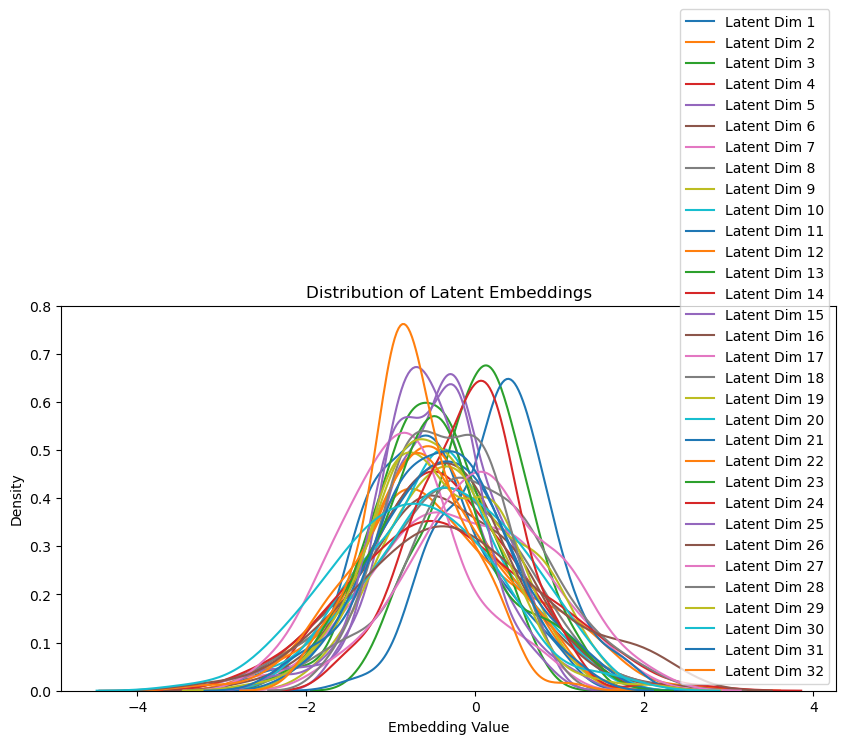

In [ ]:

import torch
import seaborn as sns
import matplotlib.pyplot as plt

def plot_embedding_distribution(embeddings):
    embeddings = embeddings.numpy()
    plt.figure(figsize=(10, 5))
    
    # Plot histogram for each latent dimension
    for i in range(embeddings.shape[1]):
        sns.kdeplot(embeddings[:, i], label=f"Latent Dim {i+1}")
    
    plt.title("Distribution of Latent Embeddings")
    plt.xlabel("Embedding Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

plot_embedding_distribution(test_embeddings)


'''
2. Given all the loss, what do you think is the problem? How can I improve the model?
Looking at the loss components, here are some potential problems and improvement suggestions:

1. High Reconstruction Loss
Problem: The reconstruction loss (L2 norm) seems to be quite high compared to the other losses, even though it should be helping the embeddings to capture structure. A high reconstruction loss suggests that the model is struggling to map the latent variables back to a meaningful representation of the input graph data.
Solution: The high reconstruction loss could be a sign of overfitting or instability. Try the following:
Regularization: Apply dropout to both the encoder and decoder layers to avoid overfitting. You could also use weight decay in the optimizer.
Decoder refinement: Check if the decoder needs a more sophisticated architecture. If the decoder is too simple (a single linear layer), it might not be sufficient to effectively reconstruct meaningful graph features.
Learning rate adjustment: Try to lower the learning rate slightly, as high reconstruction loss can sometimes be caused by large updates at each step.
2. KL Divergence is significant
Problem: The KL divergence is still noticeable throughout the training, which could indicate that your model is struggling to learn a meaningful latent space distribution.
Solution: The model may be failing to regularize the latent space properly. Consider the following:
KL annealing: Use a gradually increased weight for the KL divergence loss (starting small and increasing it over epochs). This can allow the model to first focus on learning good representations and only later on regularizing the latent space.
Prior distribution: Double-check if your prior mean and log variance (set to zeros) are appropriate. If necessary, you could experiment with different priors.
3. Ranking Loss Behavior
As mentioned, the ranking loss is not changing, which is a concern. This could indicate that your embeddings aren't differing much, preventing any real optimization in the pairwise relationships.
Solution: In addition to the previous suggestions (e.g., reducing the margin), consider:
Enhanced attention in GAT: Since you're using GAT layers instead of GCN, experiment with different attention mechanisms (e.g., using multi-head attention). This could potentially capture more useful relational information.
Edge importance: In graph attention networks, edges have weights that represent their importance. Experiment with different ways of learning edge importance, as this may help improve your ranking loss.
4. Batch Size & Learning Dynamics
Problem: Your batch size and optimizer settings could influence the loss dynamics. A large batch size can lead to slow updates, while a small batch size might introduce noise.
Solution: Try adjusting the batch size to see how the loss dynamics change. Additionally, consider adaptive optimizers like AdamW, which can help better regularize the learning process.
5. Hyperparameter Tuning
The issue could also stem from hyperparameters like hidden dimensions, latent dimensions, and attention heads in your GAT layers.
Solution: Experiment with tuning the hidden dimensions or latent space size. Make sure the latent space is large enough to capture meaningful relationships but not too large, as it could overfit or complicate training.
'''